In [85]:
import requests
import pandas as pd
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# URL do novo arquivo no GitHub
url = "https://raw.githubusercontent.com/adirsonmfjr/credito-rural/main/Dados_Estoque_credito_rural_1993-2023.xls"

# Baixar o arquivo
response = requests.get(url)

if response.status_code == 200:
    # Carregar o Excel com ajustes
    df = pd.read_excel(
        BytesIO(response.content),
        sheet_name="Séries",  # Nome da aba no Excel
        engine="xlrd",
        dtype=str  # Lê como string para evitar conversões erradas
    )

    # Converter colunas numéricas para float e substituir NaN por 0
    for col in df.columns[3:]:  # Pular as três primeiras colunas (Sigla, Código, Município)
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    print("Arquivo carregado com sucesso!")

else:
    print("Erro ao baixar o arquivo:", response.status_code)

# Configurar pandas para exibir valores sem notação científica
pd.set_option('display.float_format', '{:,.0f}'.format)

# Exibir as primeiras linhas para verificar se faz sentido
df.head()


Arquivo carregado com sucesso!


,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,20776771,8562961,11362390,11235470,14613649,15877934,9088736,8996591,6580221,4908745
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,3197656,35660,334018,5179684,1636721,924183,297710,524263,112330,151097
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,8906259,9917391,16527385,13863737,11236307,10363271,7850346,3423072,3098155,3913477
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,16035479,18792652,9158576,10670679,17666324,14845991,6806347,9281610,4009833,3910707
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,4519761,3421325,4075607,3578121,11337150,6119740,3826153,2452279,6232797,3550908


In [86]:
# Parte 2 - Cálculo das Métricas RFM
# ----------------------------------

# Identificar as colunas de anos (ignorar colunas categóricas)
colunas_anos = [col for col in df.columns if col.isdigit()]  # Filtra apenas colunas com nome numérico

# Criar colunas de Data Inicial e Data Final
df["Data_Inicial"] = int(min(colunas_anos))  # Primeiro ano disponível na base
df["Data_Final"] = int(max(colunas_anos))    # Último ano disponível na base

# Função para calcular a Recência (R)
def calcular_recencia(row):
    anos_com_estoque = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Filtra os anos com estoque positivo
    if anos_com_estoque:
        return df["Data_Final"].iloc[0] - max(anos_com_estoque)  # Último ano com estoque - Data Final
    return df["Data_Final"].iloc[0] - df["Data_Inicial"].iloc[0]  # Caso não haja estoque em nenhum ano

# Aplicar a função de Recência
df["Recencia"] = df.apply(calcular_recencia, axis=1)

# Criar a coluna de Frequência (F) - Contagem de anos com estoque positivo
df["Frequencia"] = (df[colunas_anos] > 0).sum(axis=1)

# Criar a coluna Monetário (M) - Soma total dos estoques ao longo do período
df["Monetario"] = df[colunas_anos].sum(axis=1)

# Verificar as métricas RFM
df[["Recencia", "Frequencia", "Monetario"]].head(15)


,Recencia,Frequencia,Monetario
0,0,29,231741082
1,0,29,41216925
2,0,31,177560391
3,0,29,257391191
4,0,26,98085601
5,0,31,73294608
6,0,26,62018956
7,0,30,64958872
8,0,14,1310817
9,0,25,17574727


In [87]:
# Parte 3 - Cálculo da Longevidade (L) e Ajuste da Estrutura do DataFrame
# ----------------------------------------------------------------------

# Criar uma cópia do dataframe para os cálculos LFM
rfm = df.copy()

# Garantir que a coluna "Município" seja preservada
rfm["Município"] = df["Município"]  # Verifique se o nome tem acento, pode ser "Município" ou "Municipio"

# Criar a coluna de Longevidade (L) como o intervalo entre o primeiro e o último ano com crédito
def calcular_longevidade(row):
    anos_validos = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Filtra os anos com crédito positivo

    if anos_validos:
        return max(anos_validos) - min(anos_validos)  # Último ano - Primeiro ano
    return 0  # Caso nunca tenha pego crédito

# Aplicar a função para calcular Longevidade
rfm["Longevidade"] = rfm.apply(calcular_longevidade, axis=1)

# Reorganizar as colunas para que 'Longevidade' fique antes de 'Recencia'
colunas = list(rfm.columns)
colunas.insert(colunas.index("Recencia"), colunas.pop(colunas.index("Longevidade")))
rfm = rfm[colunas]

# Exibir os dados processados para verificar se está condizente
rfm.head(15)


,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,2020,2021,2022,2023,Data_Inicial,Data_Final,Longevidade,Recencia,Frequencia,Monetario
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,9088736,8996591,6580221,4908745,1993,2023,28,0,29,231741082
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,297710,524263,112330,151097,1993,2023,30,0,29,41216925
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,7850346,3423072,3098155,3913477,1993,2023,30,0,31,177560391
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,6806347,9281610,4009833,3910707,1993,2023,28,0,29,257391191
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,3826153,2452279,6232797,3550908,1993,2023,26,0,26,98085601
5,AC,1200203,Cruzeiro do Sul,4174121,9793970,2930975,740449,45919,25763,4497267,...,31543,203373,402895,640146,1993,2023,30,0,31,73294608
6,AC,1200252,Epitaciolândia,0,0,0,0,17272,0,691557,...,865635,835638,1778101,2170744,1993,2023,26,0,26,62018956
7,AC,1200302,Feijó,157460,736830,0,1741801,606447,152267,1598423,...,1188992,3894594,1909744,3713996,1993,2023,30,0,30,64958872
8,AC,1200328,Jordão,0,0,0,0,0,0,0,...,0,84320,71173,100581,1993,2023,23,0,14,1310817
9,AC,1200336,Mâncio Lima,0,0,0,0,0,0,45506,...,286632,256381,259203,570000,1993,2023,24,0,25,17574727


In [88]:
# Parte 4 - Segmentação LFM
# --------------------------

# Criar scores LFM por quintis (1 a 5)
rfm["score_L"] = pd.qcut(rfm["Longevidade"], 5, labels=False, duplicates='drop') + 1
rfm["score_R"] = pd.qcut(-rfm["Recencia"], 5, labels=False, duplicates='drop') + 1  # Recência invertida (quanto menor, melhor)
rfm["score_F"] = pd.qcut(rfm["Frequencia"], 5, labels=False, duplicates='drop') + 1
rfm["score_M"] = pd.qcut(rfm["Monetario"], 5, labels=False, duplicates='drop') + 1

# Exibir as primeiras linhas da segmentação
rfm.head(15)


,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,Data_Inicial,Data_Final,Longevidade,Recencia,Frequencia,Monetario,score_L,score_R,score_F,score_M
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,1993,2023,28,0,29,231741082,1,1,2,4
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,1993,2023,30,0,29,41216925,2,1,2,2
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,1993,2023,30,0,31,177560391,2,1,2,4
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,1993,2023,28,0,29,257391191,1,1,2,4
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,1993,2023,26,0,26,98085601,1,1,1,3
5,AC,1200203,Cruzeiro do Sul,4174121,9793970,2930975,740449,45919,25763,4497267,...,1993,2023,30,0,31,73294608,2,1,2,3
6,AC,1200252,Epitaciolândia,0,0,0,0,17272,0,691557,...,1993,2023,26,0,26,62018956,1,1,1,3
7,AC,1200302,Feijó,157460,736830,0,1741801,606447,152267,1598423,...,1993,2023,30,0,30,64958872,2,1,2,3
8,AC,1200328,Jordão,0,0,0,0,0,0,0,...,1993,2023,23,0,14,1310817,1,1,1,1
9,AC,1200336,Mâncio Lima,0,0,0,0,0,0,45506,...,1993,2023,24,0,25,17574727,1,1,1,1


In [94]:
import numpy as np
import pandas as pd

# Criando o Score Médio LFM (média dos três scores)
rfm["score_LFM"] = (rfm["score_L"] + rfm["score_F"] + rfm["score_M"]) / 3

# Definição das condições para a classificação baseada no Score Médio LFM
condicoes = [
    (rfm["score_LFM"] >= 4.5),  # Demanda de Alta Intensidade
    (rfm["score_LFM"] >= 3.5) & (rfm["score_LFM"] < 4.5),  # Demanda de Média-Alta Intensidade
    (rfm["score_LFM"] >= 2.5) & (rfm["score_LFM"] < 3.5),  # Demanda de Média Intensidade
    (rfm["score_LFM"] >= 1.5) & (rfm["score_LFM"] < 2.5),  # Demanda de Média-Baixa Intensidade
    (rfm["score_LFM"] < 1.5)  # Demanda de Baixa Intensidade
]

# Correspondência das classificações de demanda
categorias = [
    "Demanda de Alta Intensidade",
    "Demanda de Média-Alta Intensidade",
    "Demanda de Média Intensidade",
    "Demanda de Média-Baixa Intensidade",
    "Demanda de Baixa Intensidade"
]

# Aplicando a classificação ao dataframe
rfm["classificacao_LFM"] = np.select(condicoes, categorias, default="Outros Municípios")

# Exportar a tabela completa para um arquivo XLSX
rfm.to_excel("lfm_classificacao.xlsx", index=False)

# Exibir as primeiras linhas da classificação
rfm.head(15)


,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,Longevidade,Recencia,Frequencia,Monetario,score_L,score_R,score_F,score_M,classificacao_LFM,score_LFM
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,28,0,29,231741082,1,1,2,4,Demanda de Média-Baixa Intensidade,2
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,30,0,29,41216925,2,1,2,2,Demanda de Média-Baixa Intensidade,2
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,30,0,31,177560391,2,1,2,4,Demanda de Média Intensidade,3
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,28,0,29,257391191,1,1,2,4,Demanda de Média-Baixa Intensidade,2
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,26,0,26,98085601,1,1,1,3,Demanda de Média-Baixa Intensidade,2
5,AC,1200203,Cruzeiro do Sul,4174121,9793970,2930975,740449,45919,25763,4497267,...,30,0,31,73294608,2,1,2,3,Demanda de Média-Baixa Intensidade,2
6,AC,1200252,Epitaciolândia,0,0,0,0,17272,0,691557,...,26,0,26,62018956,1,1,1,3,Demanda de Média-Baixa Intensidade,2
7,AC,1200302,Feijó,157460,736830,0,1741801,606447,152267,1598423,...,30,0,30,64958872,2,1,2,3,Demanda de Média-Baixa Intensidade,2
8,AC,1200328,Jordão,0,0,0,0,0,0,0,...,23,0,14,1310817,1,1,1,1,Demanda de Baixa Intensidade,1
9,AC,1200336,Mâncio Lima,0,0,0,0,0,0,45506,...,24,0,25,17574727,1,1,1,1,Demanda de Baixa Intensidade,1


<ipython-input-95-ff8e9fcba12a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=rfm["classificacao_LFM"],


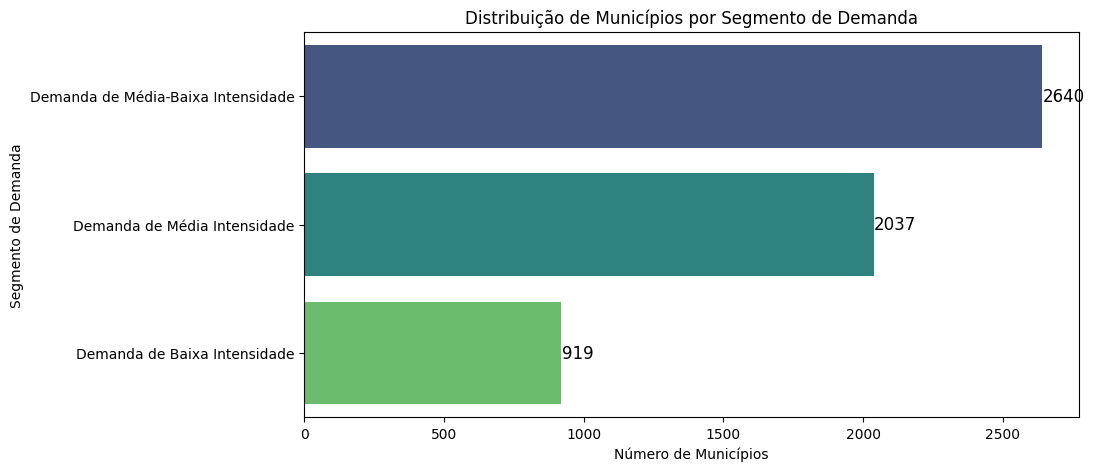

<ipython-input-95-ff8e9fcba12a>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x="classificacao_LFM", y="Longevidade", palette="viridis", ax=axes[0])
<ipython-input-95-ff8e9fcba12a>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-95-ff8e9fcba12a>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x="classificacao_LFM", y="Frequencia", palette="viridis", ax=axes[1])
<ipython-input-95-ff8e9fcba12a>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

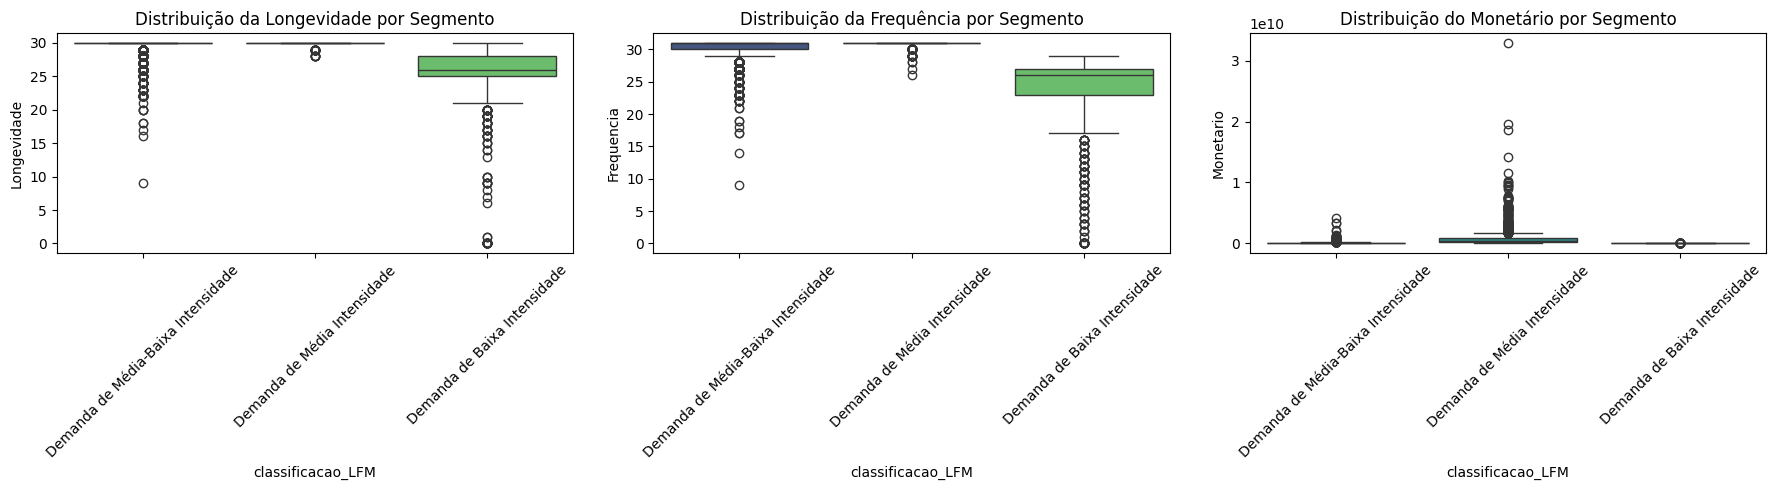

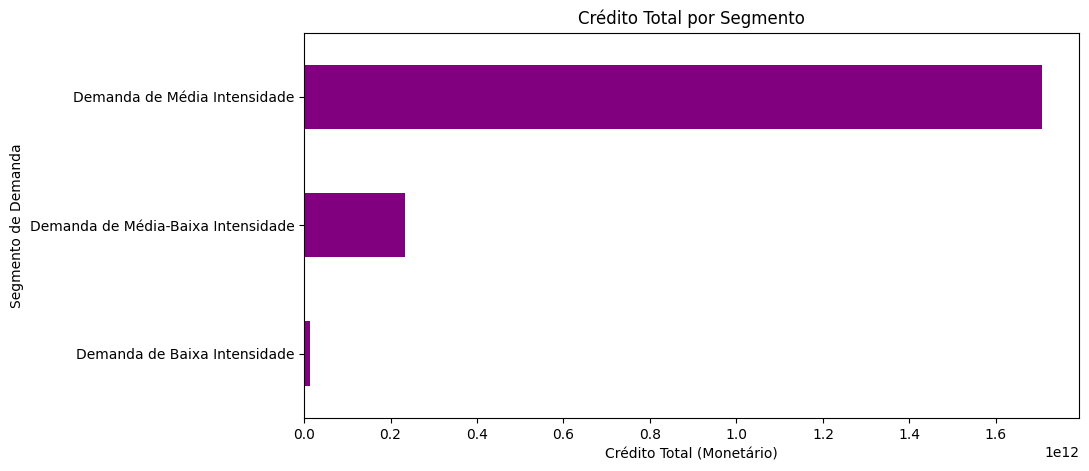

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contagem de municípios por segmento
segmentos_contagem = rfm["classificacao_LFM"].value_counts()

# 1️⃣ Gráfico de Barras - Quantidade de Municípios por Segmento
plt.figure(figsize=(10, 5))
ax = sns.countplot(y=rfm["classificacao_LFM"],
                   order=segmentos_contagem.index,
                   palette="viridis")

# Adicionar rótulos com a contagem de municípios
for i, count in enumerate(segmentos_contagem):
    ax.text(count + 2, i, str(count), va='center', fontsize=12)

plt.xlabel("Número de Municípios")
plt.ylabel("Segmento de Demanda")
plt.title("Distribuição de Municípios por Segmento de Demanda")
plt.show()

# 2️⃣ Boxplot - Comparação de Longevidade, Frequência e Monetário por Segmento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=rfm, x="classificacao_LFM", y="Longevidade", palette="viridis", ax=axes[0])
axes[0].set_title("Distribuição da Longevidade por Segmento")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(data=rfm, x="classificacao_LFM", y="Frequencia", palette="viridis", ax=axes[1])
axes[1].set_title("Distribuição da Frequência por Segmento")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(data=rfm, x="classificacao_LFM", y="Monetario", palette="viridis", ax=axes[2])
axes[2].set_title("Distribuição do Monetário por Segmento")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# 3️⃣ Crédito Total por Segmento
plt.figure(figsize=(10, 5))
rfm.groupby("classificacao_LFM")["Monetario"].sum().sort_values().plot(kind="barh", color="purple")
plt.xlabel("Crédito Total (Monetário)")
plt.ylabel("Segmento de Demanda")
plt.title("Crédito Total por Segmento")
plt.show()


In [ ]:
Mapa

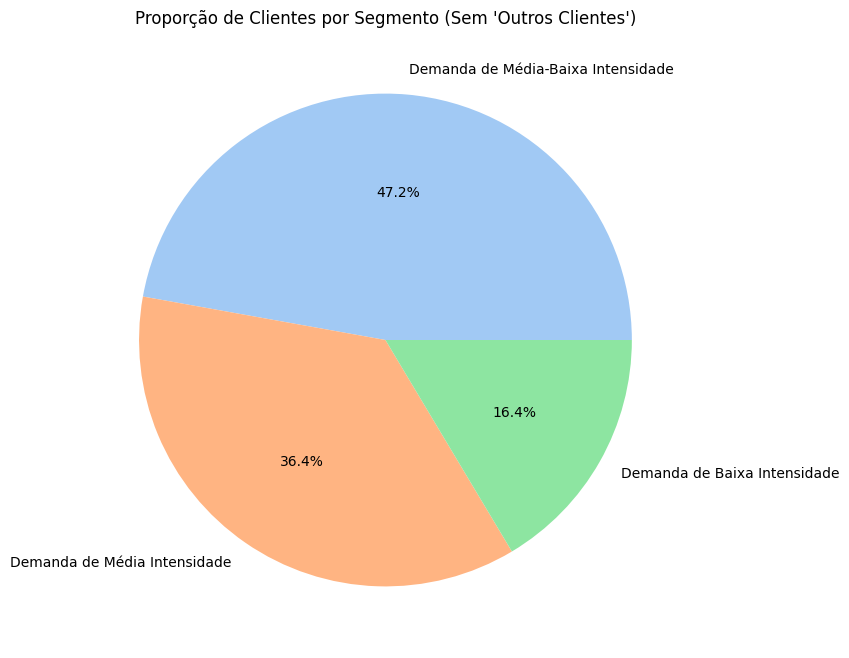

In [83]:
plt.figure(figsize=(8, 8))
rfm_filtrado["classificacao_LFM"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Proporção de Clientes por Segmento (Sem 'Outros Clientes')")
plt.ylabel("")
plt.show()
